# Tutorial: Entendimiento de los datos con PySpark

## Introducción
    ¿Qué aprenderá? 
    En este tutorial aprenderá cómo puede realizar el entendimiento de los datos en el contexto de un proyecto de analítica. A nivel de la metodología ASUM-DM estamos en la fase de entendimiento de datos y en la arquitectura nos encontramos trabajando con el componente de fuentes de datos.

    ¿Qué construirá? 
    En este tutorial realizará la exploración o perfilamiento de un conjunto de datos provenientes de una base de datos relacional, al igual que un análisis de la calidad de los datos utilizando los DataFrames de PySpark. Además, generará las conclusiones requeridas para ser compartidas en reuniones y formalizadas en la documentación del proyecto. Las conclusiones son variadas pero en general podemos decir que siempre deberían incluir una lista de preguntas o aclaraciones para la organización, conclusiones de los datos/problemas de calidad y alternativas para la limpieza. Un entendimiento de datos sin conclusiones no es útil y tampoco es entendible para personas de negocio.
    
    ¿Para qué?
    Antes de realizar cualquier tipo de proyecto de datos es necesario entender los datos con unas tareas de exploración o perfilamiento de datos y de análisis de calidad. Esta fase de la metodología permite determinar si es posible o no realizar el proyecto dada la cantidad y calidad de los datos, el tiempo requerido para su preparación y las diferentes actividades que se requieren para mejorar los datos en caso de requerirse.  
    
    ¿Qué necesita?
    Los siguientes requisitos se encuentran instalados en la máquina virtual asignada a cada estudiante, específicamente en el ambiente de anaconda llamado "Tutoriales". Recuerde que tiene a su disposición el tutorial de conexión a máquinas virtuales en la semana 1 de Coursera
    1. Python 3 con pip instalado
    2. Jupyter Labs
    3. Paquetes: Pyspark (3.2.1), pandas (1.2.1), numpy (1.20.0) y matplotlib (3.3.4)
    Otros:
    1. Controlador Connector J(ya se encuentra configurado)
    2. Acceso a servidor remoto MySQL con base de datos relacional "WWImportersTransactional". Recuerde que tiene a su disposición el tutorial de conexión remoto a Mysql en la semana 1 de Coursera


Continuando con el proyecto de consultoria de Wide World Importers, el primer paso para iniciar la comprensión de los datos es explorar y entender las fuentes de datos disponibles. Note que esto también nos ayuda a comprender mejor la organización.

## Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python
necesarios

In [82]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
#import matplotlib.pyplot as plt
import numpy as np

Configuración del controlador e inicio de sesion Spark

In [83]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [84]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at C:\Users\estudiante\AppData\Local\Temp\ipykernel_8580\1218200805.py:5 

In [85]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/WWImportersTransactional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_24_202315'
db_psswd = 'aabb1122'

PATH='./'

## Perfilamiento de los datos
El perfilamiento se basa en varios aspectos: **entendimiento general** de los datos compartidos, validación de **reglas de negocio**, **análisis descriptivo** utilizando estadística descriptiva y diagramas para la visualización de los datos y **análisis de calidad**. El primero hace referencia a tener una comprensiòn global antes de entrar en los detalles, la segunda sobre las reglas, corresponden a especificaciones dadas por el negocio en relación con los datos, un ejemplo de regla de negocio dada es: "Todo producto de la canasta familiar debe tener un precio de IVA equivalente a 19%", dada esta regla de negocio, se debe revisar en los datos suministrados que no hayan valores de IVA menores a 19%. En el tercer aspecto, relacionado con el análisis descriptivo, se revisan estadísticas: mínimo, máximo, media, mediana, distribuciones de los datos, valores nulos, cardinalidad con el fin de comprender en mayor nivel de profundidad los datos compartidos.


### Información dada por la organización relacionada con los datos
El grupo de consultores de analitica descriptiva de Wide World Importers asegura que las tablas Grupo de compras, Ciudades, Colores, Paises, Clientes, Categorias de clientes, Paquetes, Estados y provincias, Productos y Personas ya fueron perfiladas y corregidos; sin embargo le recomiendan revisar el diccionario suministrado dado que todas las tablas serán utilizadas en futuros requerimientos (tutoriales y ejercicios) que lo encuentra [aqui](./Diccionario%20WWImporters.xlsx). Si tienen alguna duda relacionada con estas tablas deben incluirla en las preguntas o aclaraciones que le entreguen a la organización como parte del resultado de esta fase de entendimiento.

En este punto de la consultorìa, nuestra responsabilidad es analizar las tablas ordenes y detalles de ordenes, relacionadas con al proceso de ordenes de compra de productos. Con respecto a esas fuentes nos comentan lo siguiente:

- La tasa de impuesto es de 10% o 15%
- Son 107.707 órdenes detalladas en 231.412 lineas de detalle de órdenes realizadas desde 2013
- El formato de fechas manejado es YYYY-MM-DD HH:MM:SS si tienen hora, minutos y segundos. De lo contrario el formato es YYYY-MM-DD


### Conexión a fuente de datos y acceso a los datos

#### Conexión a fuente de datos
A continuación encuentra las funciones para conectarse a la fuente de datos (archivo csv o base de datos) y retornar un dataframe que es el que se utilizará posteriormente para manipular los datos.

In [86]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos
Para consultar desde la base de datos se puede acceder directamente a la tabla dado su nombre o se puede especificar la sentencia SQL de un "SELECT" completo para traer la información total o parcial de la tabla que se requiere. A continuación un ejemplo de cada uno de estos usos. 
Acceso directo para el caso de órdenes y acceso con sentencia SQL para el caso de detallesOrdenes.

In [87]:
sql_ordenes = 'WWImportersTransactional.OrdenesCopia'

In [88]:
sql_detallesOrdenes = '''(SELECT 
        Detalle_orden_ID, 
        ID_de_pedido, 
        ID_Producto, 
        Descripcion, 
        ID_Tipo_Paquete, 
        Cantidad, 
        Precio_unitario, 
        Tasa_de_impuesto, 
        Cantidad_seleccionada, 
        Seleccion_completada_cuando 
        FROM WWImportersTransactional.DetallesOrdenesCopia) AS Compatible'''

In [89]:
#Se cargan los dataframes desde la base de datos
ordenes = obtener_dataframe_de_bd(db_connection_string, sql_ordenes, db_user, db_psswd)
detallesOrdenes = obtener_dataframe_de_bd(db_connection_string, sql_detallesOrdenes, db_user, db_psswd)

### Entendimiento general de datos

Para ver una muestra de los datos, utilice el comando <i>show</i> ingresando el número de filas que quiere ver

In [90]:
ordenes.show(5)

+------------+-------------+--------------+------------------------------+-------------------------+----------------------+---------------+-------------------------+--------------------------------------+-------------------------------------------+-----------+------------------------+--------------------+---------------------------+
|ID_de_pedido|ID_de_cliente|ID_de_vendedor|Seleccionado_por_ID_de_persona|ID_de_persona_de_contacto|ID_de_pedido_pendiente|Fecha_de_pedido|Fecha_de_entrega_esperada|Numero_de_pedido_de_compra_del_cliente|Pedido_pendiente_de_suministro_insuficiente|Comentarios|Instrucciones_de_entrega|Comentarios_internos|Seleccion_completada_cuando|
+------------+-------------+--------------+------------------------------+-------------------------+----------------------+---------------+-------------------------+--------------------------------------+-------------------------------------------+-----------+------------------------+--------------------+------------------------

In [14]:
detallesOrdenes.show(5)

+----------------+------------+-----------+--------------------+---------------+--------+---------------+----------------+---------------------+---------------------------+
|Detalle_orden_ID|ID_de_pedido|ID_Producto|         Descripcion|ID_Tipo_Paquete|Cantidad|Precio_unitario|Tasa_de_impuesto|Cantidad_seleccionada|Seleccion_completada_cuando|
+----------------+------------+-----------+--------------------+---------------+--------+---------------+----------------+---------------------+---------------------------+
|          206857|       65697|        205|Tape dispenser (B...|              7|      60|             32|              15|                   60|        2016-01-27 11:00:00|
|          206858|       65698|         45|Developer joke mu...|              7|       3|             13|              15|                    3|        2016-01-27 11:00:00|
|          206859|       65698|         72|Ride on toy sedan...|              7|       3|            230|              15|             

Como puede observar en la tabla de ordenes tenemos información **relacionada con el cliente, el empleado y con la órden**. La información del cliente es su identificador <i>ID_de_cliente</i>, el identificador de la persona que eligió la órden <i>eleccionado_por_ID_de_persona</i>, el identificador de la persona de contacto <i>ID_de_persona_de_contacto</i>, el <i>Número_de_pedido_de_compra_del_cliente</i>. La información del empleado es su identificador <i>ID_de_vendedor</i>. La información de la órden es: el identificador de la órden <i>ID_de_pedido</i>, el identificador que indica si es un pedido pendiente <i>ID_de_pedido_pendiente</i>, la fecha en la que se realizó el pedido <i>Fecha_de_pedido</i>, la fecha de entrega esperada del pedido <i>Fecha_de_entrega_esperada</i> y <i>Pedido_pendiente_de_suministro_insuficiente</i> que indica si es un pedido pendiente o no.
El esquema de un DataFrame incluye los nombres de las columnas asi como el tipo de dato. Recuerde que tipo de dato (e.g., booleano, caracteres, enteros, flotantes, colecciones) es diferente a tipo de variable (numérica y categórica).

In [94]:
ordenes.schema

StructType(List(StructField(ID_de_pedido,IntegerType,true),StructField(ID_de_cliente,IntegerType,true),StructField(ID_de_vendedor,IntegerType,true),StructField(Seleccionado_por_ID_de_persona,IntegerType,true),StructField(ID_de_persona_de_contacto,IntegerType,true),StructField(ID_de_pedido_pendiente,IntegerType,true),StructField(Fecha_de_pedido,StringType,true),StructField(Fecha_de_entrega_esperada,StringType,true),StructField(Numero_de_pedido_de_compra_del_cliente,StringType,true),StructField(Pedido_pendiente_de_suministro_insuficiente,BooleanType,true),StructField(Comentarios,StringType,true),StructField(Instrucciones_de_entrega,StringType,true),StructField(Comentarios_internos,StringType,true),StructField(Seleccion_completada_cuando,TimestampType,true)))

Por otra parte, en los detalles de ordenes se tiene **información del pedido y del producto**. Del pedido se tiene el identificador del detalle <i>Detalle_orden_ID</i>, el identificador de la orden a la que está relacionado cada detalle <i>ID_de_pedido</i>, la <i>Cantidad_seleccionada</i> del producto para la orden, la fecha de selección <i>Seleccion_completada_cuando</i>. Del producto tenemos el <i>ID_Producto</i>, su <i>Descripcion</i>, el tipo de paquete <i>ID_Tipo_Paquete</i> (Ej. 1.Bolsa, 4. Caja), la <i>Cantidad</i>, el <i>Precio_unitario</i>, y la <i>Tasa_impuesto</i> asociada a ese producto. Una primera aclaración a solicitar por parte del negocio es cuál es la diferencia entre cantidad y cantidad seleccionada

In [95]:
detallesOrdenes.schema

StructType(List(StructField(Detalle_orden_ID,IntegerType,true),StructField(ID_de_pedido,IntegerType,true),StructField(ID_Producto,IntegerType,true),StructField(Descripcion,StringType,true),StructField(ID_Tipo_Paquete,IntegerType,true),StructField(Cantidad,IntegerType,true),StructField(Precio_unitario,DecimalType(10,0),true),StructField(Tasa_de_impuesto,DecimalType(10,0),true),StructField(Cantidad_seleccionada,IntegerType,true),StructField(Seleccion_completada_cuando,TimestampType,true)))

**¿Qué es una fila de cada fuente compartida?**
Con estos análisis podemos concluir que una fila de órdenes representa la órden realizada por un cliente y atendida por un empleado. Mientras que el detalle de órden coincide con su nombre y contiene el detalle de cada producto solicitado en una órden.

Una vez entendida en términos generales la estructura de los datos, es necesario conocer la cantidad de datos disponibles, esto se hace con count() y con columns, que retornan el número de filas y número de columnas respectivamente.

In [96]:
print((detallesOrdenes.count(), len(detallesOrdenes.columns)),(ordenes.count(), len(ordenes.columns)))

(58320, 10) (88258, 14)


**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 58.320 órdenes y 88.258 detalles de orden y tenemos en total 24 variables a revisar de las cuales 8 son nùmericas asociadas a las órdenes, dos son de tipo fecha y las demás son cadenas de caracteres.

### Revisión de reglas de negocio 

Primero se confirman las reglas proporcionadas por el negocio, la primera que asegura que la tasa de impuesto es de 10% o 15% vemos que no es correcta pues al seleccionar esa columna e indicar que queremos ver los valores distintos que puede tomar se observa únicamente el valor 15

In [97]:
detallesOrdenes.select("Tasa_de_impuesto").distinct().show()

+----------------+
|Tasa_de_impuesto|
+----------------+
|              15|
+----------------+



Si se quiere saber cuántos registros hay por cada valor posible, existen varias formas de hacerlo, en la siguiente celda se muestra cómo iterar sobre los valores resultado de una consulta y cómo filtrar el número de registros para cada valor usando filter y select where, también se da un ejemplo de uso de group by y agregaciones

Pyspark tiene funcionalidades de los DataFrames que permiten explorar los datos por medio de agregaciones y estas funcionan similar a como se usan en SQL

Primero, se debe agrupar sobre una columna con el método <i>groupBy</i> y después se pueden realizar agregaciones sobre otras columnas con el método <i>agg</i>. La sintaxis es la siguiente: 
 ``` 
    DataFrame.groupBy('COLUMN NAME').agg({'COLUMN NAME 1': 'mean', 'COLUMN NAME 2': 'count', 'COLUMN NAME 3': 'max'})
  ``` 

En cualquiera de los 3 casos se observa que el resultado es el mismo

In [98]:
for row in detallesOrdenes.select('Tasa_de_impuesto').distinct().collect(): 
    texto = 'número de registros con '+str(row.Tasa_de_impuesto)+ '% de tasa de impuesto: '
    opc1 ="--Usando filter--"
    print(texto+opc1+str(detallesOrdenes.filter(col('Tasa_de_impuesto')==row.Tasa_de_impuesto).count()))
    
    opc2 ="--Usando Select where--"
    print(texto+opc2+str(detallesOrdenes.select().where(col('Tasa_de_impuesto')==row.Tasa_de_impuesto).count()))
    opc3 ="--Usando group by--"
detallesOrdenes.groupBy("Tasa_de_impuesto").count().show()

número de registros con 15% de tasa de impuesto: --Usando filter--58320
número de registros con 15% de tasa de impuesto: --Usando Select where--58320
+----------------+-----+
|Tasa_de_impuesto|count|
+----------------+-----+
|              15|58320|
+----------------+-----+



La conclusión es entonces que la regla no es completamente cierta, pues en los datos no hay ningun registro con tasa_de_impuesto de 10%, es necesario pedir aclaraciones al negocio en relación a este descubrimiento. La segunda regla de negocio implica conocer el número de registros y de variables que los describen, es decir, el número de filas y columnas del DataFrame respectivamente, esto se logra usando count() y columns

In [99]:
print((detallesOrdenes.count(), len(detallesOrdenes.columns)),(ordenes.count(), len(ordenes.columns)))

(58320, 10) (88258, 14)


Podemos concluir que esta regla de negocio no es cierta dado que el número de registros no parece coincidir con el número dado por el negocio, una primera intuición nos dice que podrían haber registros duplicados y si existen hay que reportarlos y eliminarlos en la fase de preparación de los datos. Esta es la primera conclusión del análisis de entendimiento de datos.

In [100]:
detallesOrdenes.distinct().count(), ordenes.distinct().count() 

(58239, 74179)

Como pueden ver hay 58.239 detalles de orden y 74.179 ordenes únicas. Es decir que sabemos que hay 14.079 ordenes completamente repetidas, pero entonces ¿por qué el número de detalles de orden que hay en los datos no coincide con el dado por la organización? 

La respuesta es que no basta solo con revisar si hay registros idénticos, puede que hayan registros con columnas identificadoras o lo que conoceriamos como las llaves primarias repetidas pero con diferentes valores en los otros atributos. Esto se da principalmente cuando las bases de datos están mal construidas, aunque hay casos en los cuales tiene sentido. En cualquier caso es nuestra responsabilidad preveer estos escenarios, por ende se revisan los datos por la llave primaria de esta tabla:

In [101]:
detallesOrdenes.select(col('Detalle_orden_ID')).distinct().count()

57981

De esta manera vemos que hay una diferencia de 258 registros cuyo identificador es el mismo y vemos que el número de identificadores únicos coincide con el número dado por el negocio, la segunda conclusión es entonces que tenemos 258 registros que representan el mismo detalle de orden pero con valores distintos.

Lo siguiente es verificar las fechas en los datos, nos dicen que son ordenes desde 2013 por lo que se revisa la fecha mínima del atributo Fecha_de_pedido, como se observa la fecha mínima es de 2014 enero 1, esto nos indica que la regla de negocio no es correcta o faltan datos, esta es la tercera conclusión

In [102]:
ordenes.agg({"Fecha_de_pedido": "min"}).show()

+--------------------+
|min(Fecha_de_pedido)|
+--------------------+
|          2014-01-01|
+--------------------+



 ``` 
Como ve en el comando anterior las agregaciones también se pueden realizar sin un groupBy.
 ``` 

La siguiente regla nos indica que es necesario revisar el formato de las fechas YYYY-MM-DD HH:MM:SS, un ejemplo es el atributo <i>Fecha_de_pedido</i>. Para esto vamos a hacer uso de expresiones regulares, que son patrones de búsqueda, en este caso queremos 4 dígitos entre 0 y 9 que indican el año seguido del símbolo - luego tenemos un número de 2 dígitos que puede empezar con 0 seguido de un número entre 1 y 9 (meses 01 hasta 09) o 1 seguido de 1 o 2 (meses 11 o 12), sigue otro -, y terminamos con un número de 2 dígitos que van desde el día 01 hasta el 31, se usa rlike smilar a LIKE de SQL

In [103]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = ordenes.filter(ordenes["Fecha_de_pedido"].rlike(regex))
print("Número total de ordenes: "+str(ordenes.count())+", número de ordenes con formato correcto: "+str(cumplenFormato.count()))

Número total de ordenes: 88258, número de ordenes con formato correcto: 68223


Para ver los registros que no cumplen con el formato podemos negar la condición del filtro con el símbolo ~ al principio:

In [104]:
noCumplenFormato = ordenes.filter(~ordenes["Fecha_de_pedido"].rlike(regex))
noCumplenFormato.count(), noCumplenFormato.select(col("Fecha_de_pedido")).show()

+---------------+
|Fecha_de_pedido|
+---------------+
|    Mar 05,2015|
|    Mar 24,2015|
|    Mar 18,2014|
|    Apr 21,2015|
|    Nov 11,2014|
|    Oct 16,2014|
|    May 04,2015|
|    Nov 24,2014|
|    May 07,2015|
|    Sep 10,2014|
|    Nov 03,2015|
|    Dec 19,2014|
|    Apr 27,2016|
|    Apr 28,2016|
|    Sep 23,2014|
|    Oct 02,2015|
|    Jun 11,2014|
|    Feb 17,2014|
|    Aug 14,2015|
|    Dec 25,2015|
+---------------+
only showing top 20 rows



(20035, None)

Concluimos entonces, que hay 20.035 registros cuya fecha no cumple con el formato especificado. Sin embargo, los valores que son diferentes parecen serlo solo porque varia el formato, este tipo de casos pueden ser solucionados fácilmente por lo que una notificación al negocio sería con caracter informativo más que para solicitar una aclaración de su parte.

Para facilitar los análisis y evitar inconsistencias o conclusiones erradas vamos a estandarizar los datos, en este caso las fechas. Sin embargo, esta actividad puede hacerse sobre formatos de números, texto entre otras. 

Algo que se debe tener en cuenta en el perfilamiento de reglas de negocio es que dichas reglas pueden estar incompletas, por ende se recomienda tener especial cuidado con las columnas tipo caracter o string dado que suelen ser pasadas por alto en el análisis estadistico, un ejemplo es la columna **Descripcion**, al ser una columna de descripción del producto se espera que tenga un cierto número de caracteres. Sin embargo haciendo la validación vemos que algunas descripciones son textos incompletos como "a". Este podría llegar a ser un problema a futuro por lo que se decide notificar a la organización.

In [105]:
detallesOrdenes.where(length(col("Descripcion")) <= 10).show()

+----------------+------------+-----------+-----------+---------------+--------+---------------+----------------+---------------------+---------------------------+
|Detalle_orden_ID|ID_de_pedido|ID_Producto|Descripcion|ID_Tipo_Paquete|Cantidad|Precio_unitario|Tasa_de_impuesto|Cantidad_seleccionada|Seleccion_completada_cuando|
+----------------+------------+-----------+-----------+---------------+--------+---------------+----------------+---------------------+---------------------------+
|          206862|       65698|         10|          a|              7|       5|             32|              15|                    5|        2016-01-27 11:00:00|
|          206874|       65701|         47|          a|              7|       5|             13|              15|                    5|        2016-01-27 11:00:00|
|          206909|       65711|         37|          a|              7|       5|             13|              15|                    5|        2016-01-27 11:00:00|
|          20691

### Análisis descriptivo
Una vez cubierto lo básico de reglas de negocio, pasamos a perfilamiento estadístico. Para ver estadisticos generales como conteo, mínimo, máximo, desviación estandar y percentiles utilice summary()

In [106]:
ordenes.summary().show()

+-------+-----------------+-----------------+-----------------+------------------------------+-------------------------+----------------------+---------------+-------------------------+--------------------------------------+-----------+------------------------+--------------------+
|summary|     ID_de_pedido|    ID_de_cliente|   ID_de_vendedor|Seleccionado_por_ID_de_persona|ID_de_persona_de_contacto|ID_de_pedido_pendiente|Fecha_de_pedido|Fecha_de_entrega_esperada|Numero_de_pedido_de_compra_del_cliente|Comentarios|Instrucciones_de_entrega|Comentarios_internos|
+-------+-----------------+-----------------+-----------------+------------------------------+-------------------------+----------------------+---------------+-------------------------+--------------------------------------+-----------+------------------------+--------------------+
|  count|            88258|            88258|            88258|                         74688|                    88258|                  9223|        

En las estadísticas anteriores vemos que las columnas Comentarios, Instrucciones_de_entrega y Comentarios_internos tienen un conteo igual a 0, es decir son columnas vacías por lo que s epueden eliminar, también observamos el calculo de la media para las columnas ID, esto se hace automatico pues son columnas cuyo tipo de dato es numerico, sin embargo estas no son variables numericas por lo cual calcular y/o analizar la media no tiene sentido. La lógica es similar para los otros estadísticos, aunque podemos decir que los ID's de pedido van desde el número 19443 hasta el 73595 por ejemplo

In [107]:
detallesOrdenes.summary().show()

+-------+------------------+------------------+------------------+--------------------+---------------+------------------+-----------------+----------------+---------------------+
|summary|  Detalle_orden_ID|      ID_de_pedido|       ID_Producto|         Descripcion|ID_Tipo_Paquete|          Cantidad|  Precio_unitario|Tasa_de_impuesto|Cantidad_seleccionada|
+-------+------------------+------------------+------------------+--------------------+---------------+------------------+-----------------+----------------+---------------------+
|  count|             58320|             58320|             58320|               58320|          58320|             58320|            57337|           58320|                58320|
|   mean|152909.77184499314| 91440.73607681756|111.83144718792867|                null|            7.0|213.03914609053498|          44.5468|         15.0000|    39.74422153635117|
| stddev| 72929.99490225241|29085.094720342793| 64.32670239320214|                null|            0

En las estadíticas de orden podemos observar que el valor promedio de precio unitario es 44.54, la cantidad promedio es 213 unidades y el promedio de cantidad seleccionada es 39.74

En cuanto a la desviación estandar vemos que, por ejemplo, el precio unitario puede variar en más o menos 139.45. El valor mínimo de cantidad es 1 y el máximo es 10'000.000, de cantidad seleccionada el mínimo es 0 y el máximo 360 y de precio unitario el mínimo es 1 y el máximo 1899. Vemos por ejemplo que el valor máximo de Cantidad indica valores anómalos o extremos, pues en su percentil 75% el valor máximo era 70, es decir, para el 75% de los datos, el valor de Cantidad no superaba el 70. Observamos que la columna ID_Tipo_Paquete solo toma el valor 7, que podría ser o no un error, se notifica al negocio.

Otras formas de observar distribución o estadísticos son las graficas, de barras, de dispersión, diagramas de caja, entre otros. Por ejemplo tenemos los siguientes diagramas de caja donde se observa claramente que tenemos un valor extremo en la variable cantidad (primer grafico) y donde podemos ver los valores extremos o bigotes que determinan el punto de separación entre valores atípicos y normales, los valores atipicos, los cuartiles entre otros

{'whiskers': [<matplotlib.lines.Line2D at 0x1e804fdf388>,
 'caps': [<matplotlib.lines.Line2D at 0x1e804fdf748>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e805459408>],
 'medians': [<matplotlib.lines.Line2D at 0x1e804f79c88>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e804f79c08>],
 'means': []}

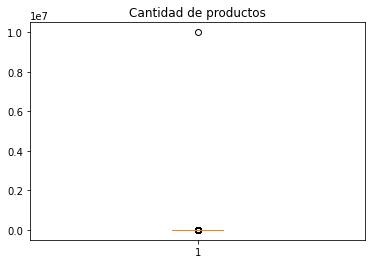

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad de productos')
ax1.boxplot(np.array(detallesOrdenes.select('Cantidad').collect()))

{'whiskers': [<matplotlib.lines.Line2D at 0x1e82e47e748>,
 'caps': [<matplotlib.lines.Line2D at 0x1e82c6cfac8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e82e47e208>],
 'medians': [<matplotlib.lines.Line2D at 0x1e8318cf1c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e8d54a5188>],
 'means': []}

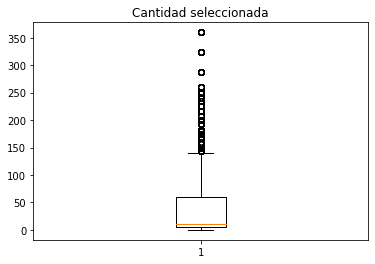

In [109]:
fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad seleccionada')

my_list = [float(i) for i in detallesOrdenes.select(f.collect_list('Cantidad_seleccionada')).first()[0]]
ax1.boxplot(my_list)

El análisis anterior es muy útil para variables de tipo numérico, sin embargo es incompleto para las variables de tipo caracter o las variables categoricas, por ende es necesario implementar nuestro propio código par obtener estadisticos como la moda y la mediana. A continuación obtenemos la moda para la variable Descripcion:

In [110]:
detallesOrdenes.groupby("Descripcion").count().orderBy("count", ascending=False).show(5)

+--------------------+-----+
|         Descripcion|count|
+--------------------+-----+
|                   a| 3225|
|Halloween skull m...|  306|
|Large  replacemen...|  305|
|"The Gu" red shir...|  303|
|"The Gu" red shir...|  296|
+--------------------+-----+
only showing top 5 rows



## Análisis de calidad de datos
La calidad de los datos consiste en validar la idoneidad de los datos analizando varias dimensiones, entre las cuales resaltamos:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores

Para asegurar una calidad mínima de los datos en estas dimensiones hay que entender su origen y posteriormente realizar un proceso de validación de cada una de las dimensiones de perfilamiento que llevará a un entendimiento de los datos disponibles.


A continuación se definen dos funciones, la primera cuenta los valores vacios por columna de dataframe, la segunda retorna un diccionario de columnas con cardinalidad superior al 50%

Te invito a revisar los recursos de calidad de datos que hemos visto en el curso, a continuacion ejemplos daremos algunos ejemplos por cada dimensión para el caso del tutorial

### Unicidad y validez

La unicidad se revisó en la segunda regla de negocio y la validez se reviso en el perfilamiento general, en la regla de negocio 3 y en el análisis de la descripción al final de la sección de revisión de reglas de negocio

### Completitud y validez

In [111]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [112]:
columnas_vacias_ordenes = contar_vacios(ordenes)
print('detalles de ordenes: ')
columnas_vacias_detalles = contar_vacios(detallesOrdenes)

número de vacíos para columna Seleccionado_por_ID_de_persona: 13570
número de vacíos para columna ID_de_pedido_pendiente: 79035
número de vacíos para columna Comentarios: 88258
número de vacíos para columna Instrucciones_de_entrega: 88258
número de vacíos para columna Comentarios_internos: 88258
número de vacíos para columna Seleccion_completada_cuando: 4347
detalles de ordenes: 
número de vacíos para columna Precio_unitario: 983
número de vacíos para columna Seleccion_completada_cuando: 982


In [113]:
columnas_alta_cardinalidad_ordenes = cardinalidad(ordenes)
columnas_alta_cardinalidad_detalles = cardinalidad(detallesOrdenes)
columnas_alta_cardinalidad_ordenes, columnas_alta_cardinalidad_detalles

({'ID_de_pedido': 54145}, {'Detalle_orden_ID': 57981, 'ID_de_pedido': 38742})

Como podemos observar para las ordenes las columnas Seleccionado_por_ID_de_persona tiene 16662 vacios, ID_de_pedido_pendiente: 96905, Comentarios: 108291, Instrucciones_de_entrega: 108291, Comentarios_internos: 108291, Seleccion_completada_cuando: 5276, mientras que para los detalles de ordenes tenemos que las columnas con vacios son Precio_unitario: 7038 y Seleccion_completada_cuando: 3186. 

Respecto a cardinalidad, solo la columna Detalle_orden_ID tiene una cardinalidad superior al 50%.

### Consistencia
A nivel de consistencia algunos ejemplos de revisión son precios negativos, productos que aparecen en las ordenes pero que no esten registrados en la tabla de produtos. En nuestro caso vamos a verificar que todas las ordenes tengan detalle de orden y viceversa

In [114]:
#consistencia: revisar genially: definicion de consistencia
ids_ordenes = set([x.ID_de_pedido for x in ordenes.select('ID_de_pedido').collect()])
ids_detalles = set([x.ID_de_pedido for x in detallesOrdenes.select('ID_de_pedido').collect()])

len(ids_ordenes-ids_detalles), len(ids_detalles-ids_ordenes)

(44359, 28956)

Como se puede observar hay una diferencia de 44.359 ordenes que no tienen detalles y hay 28.956 detalles que no tienen orden. Ninguno de los casos tiene sentido en el contexto de WideWorldImporters. Esta inconsistencia se notifica al negocio dado que no hay forma de conocer cuáles son los registros que pueden tener ids que no existen

## Herramientas para facilitar el entendimiento de datos

Algunas de las estadísticas antes desarrolladas pueden obtenerse por medio de herramientas como Pandas Profiling una herramienta muy útil, <b><i>Pero no perfecta ni completa</i></b>, es Pandas profiling que dado un conjunto de datos, nos muestra histogramas, estadísticas etc. A continuación guardamos el reporte en html

In [115]:
reporte = ProfileReport(ordenes.toPandas())
reporte.to_file(PATH+"reporte_prefilamiento.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 64.44it/s]


Lo primero que hay que notar es que hay 3 secciones principales. La primera es un resumen, la segunda es un análisis por cada variable y luego tenemos interacciones y correlaciones entre variables. 

Seccion general del reporte:
1. Tenemos 14 variables y 88.258 registros (es decir, ordenes), de las cuales 7 son numericas, 2 categoricas, 1 booleana, 1 datetime y 3 no soportadas (la herramienta entiende tipo de variable como tipo de dato, asi que la información que nos da no es necesariamente correcta en este aspecto).

2. En los datos hay 29.3% de datos vacíos, (conclusión)

3. El archivo ocupa en memoria 7.5 MB

4. No hay registros duplicados

Sección de variables del reporte:

5. Note que para cada variable nos dan estadisticos como la media, mínimo y máximo asi como un histograma de distribución de la variable, para nuestros datos no observamos nada por fuera de lo comun. (Como valores extremos)

6. La variable ID_de_pedido tiene 61.3% de valores distintos, es decir, es una variable con alta cardinalidad. Este tipo de variables no aportan a las relaciones entre filas o columnas, por lo que suelen no ser útiles a la hora de hacer análitica.

7. La variable ID_cliente tiene solo el 0,8% de valores distintos, es decir que las ordenes que tenemos parecen ser de pocos clientes, pero que podrían ser recurrentes o fieles

8. Hay 10 empleados en los datos de ordenes

9. Seleccionado_por_ID_persona tiene 15,4% de datos vacíos, no es muy alto pero podríamos eliminarla si no es importante. Preguntar al negocio

10. ID_de_pedido_pendiente tiene un porcentaje de 89,5% de valores vacíos, es casi constante y las columnas constantes no aportan a los análisis, preguntar al negocio si hay algún inconveniente en borrar esta columna

11. Hay 1512 Fecha_de_pedido distintos, siendo el 3 de febrero del 2015 una de las fechas con más número de ordenes

12. Fecha_de_entrega_esperada y Seleccion_completada_cuando tienen alta cardinalidad

Sección de interacciones y correlaciones:

Parecen haber columnas con correlaciones(Spearman) iguales a 1, esto significa que ambas columnas representan la misma información, idealmente no queremos columnas "repetidas", un ejemplo es ID_cliente y ID_de_persona_de_contacto, decidimos preguntarle al negocio si es necesario mantener ambas columnas

<b>Cabe aclarar que un pandas profiling sin interpretación no es suficiente como análisis para realizar el entendimiento de los datos.

Así mismo, recuerde que si es necesario, se debe utilizar otra herramienta (código, visualizaciones, etc) para poder completar el análisis estadístico.</b>

### Algunas gráficas utiles: Diagrama de caja, dispersion, histogramas para entender las distribuciones de las variables

Generalmente las gráficas se emplean para entender la distribución de cada variable, también sirven para visualizar la relación entre 2 o más variables

Algunas gráficas útiles son los histogramas, disepersión, diagramas de caja. Hay varias maneras de implementarlos, con paquetes como matplotlib o pandas, con funciones propias de pyspark, etc, a continuacón mostramos cómo hacerlo a travez de pandas

array([[<AxesSubplot:title={'center':'Cantidad_seleccionada'}>]],
      dtype=object)

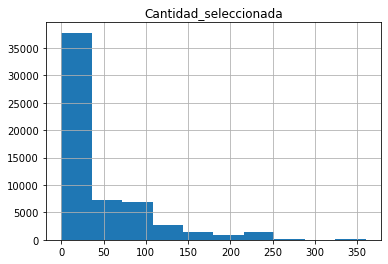

In [116]:
#para valores extremos(subir a calidad)
detallesOrdenes.toPandas().hist(column='Cantidad_seleccionada')

In [117]:
cantidades = detallesOrdenes.groupby("Cantidad").count().orderBy("count", ascending=False)

Como se puede observar, el método retorna un dataframe, que vamos a usar para obtener dos arreglos, uno con el rango de cada una de las barras y otro con la cantidad de registros por rango. Se puede usar Matplotlib para graficar esta información:

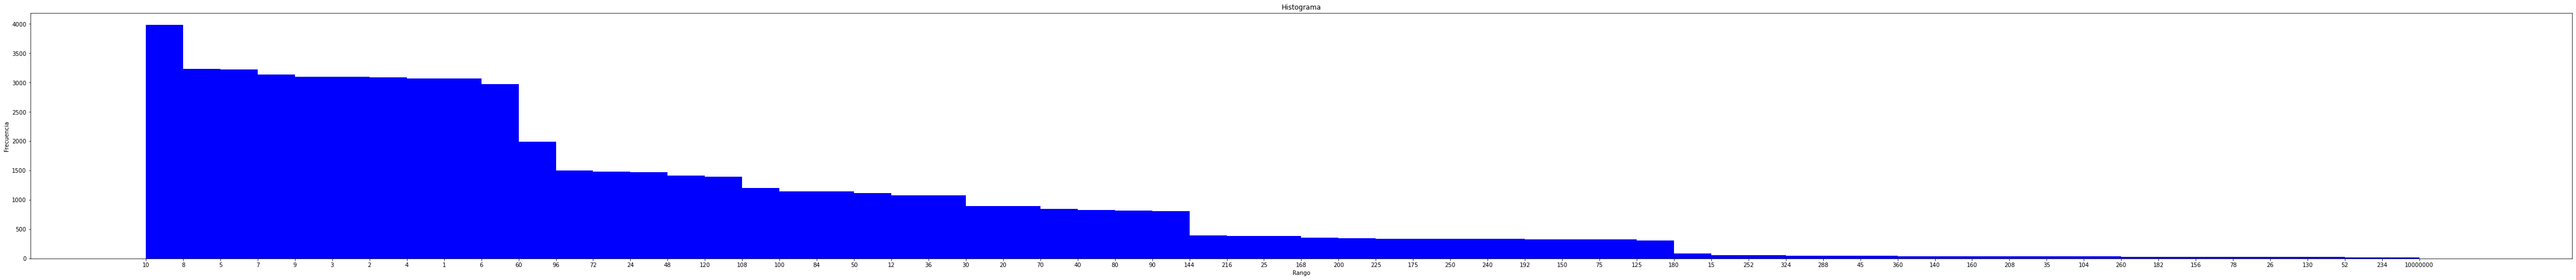

In [118]:
def plotHistogramData(data):
    binSides, binCounts = [row[0] for row in data.collect()], [row[1] for row in data.collect()]
    binSides = [round(i, 2) for i in binSides]
    N = len(binCounts)
    ind = np.arange(N)
    width = 1

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind+0.5, binCounts, width, color='b')
    
    fig.set_size_inches(1.3*N, 8)

    ax.set_ylabel('Frecuencia')
    ax.set_xlabel('Rango')
    ax.set_title('Histograma')
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(binSides)

    plt.show()

plotHistogramData(cantidades)

El diagrama de dispersion, nos muestra los datos para dos variables en forma de puntos y es muy útil para entender la relación entre dichas variables

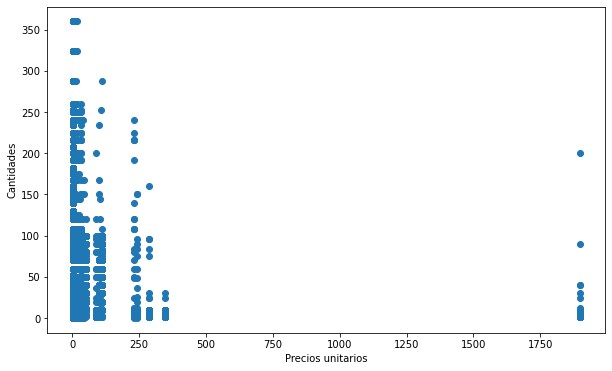

In [119]:
unitPrices = [row['Precio_unitario'] for row in detallesOrdenes.select(col('Precio_unitario')).collect()]
quantities = [row['Cantidad_seleccionada'] for row in detallesOrdenes.collect()]

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = unitPrices, y = quantities)
plt.xlabel("Precios unitarios")
plt.ylabel("Cantidades")

plt.show()

### Otras opciones de exploración
PySpark también da la opción de crear tablas de pivotes. En el siguiente ejemplo, se muestra cómo hacer una tabla que permite ver cuántas ordenes hay por cada <i>Fecha_de_pedido</i> y por cada <i>ID_de_vendedor</i>, es decir por fecha y por empleado cuantas ordenes existen:

In [120]:
ordenes.groupBy('Fecha_de_pedido').pivot('ID_de_vendedor').count().show()

+---------------+----+---+---+----+----+----+---+----+---+----+
|Fecha_de_pedido|   2|  3|  6|   7|   8|  13| 14|  15| 16|  20|
+---------------+----+---+---+----+----+----+---+----+---+----+
|     2014-12-13|   7|  8|  7|   5|   3|   6|  7|   6|  2|   6|
|     2014-05-27|   6|  7|  8|   6|   2|  11|  6|   5| 13|   6|
|     2014-02-22|   6|  4|  2|   6|   4|   3|  2|null| 11|   7|
|     2015-05-01|  22| 13| 17|   2|  14|  13|  9|  11| 19|  16|
|    Feb 27,2014|   5|  3|  6|   1|   3|null|  3|   3|  7|   1|
|     2015-02-09|   2| 13| 15|  18|   8|   6|  6|   7| 15|  15|
|    Sep 21,2015|   2|  6|  7|   6|   2|   2|  3|   3|  3|   2|
|     2014-07-14|  13| 10| 15|   7|   5|  13| 15|  10| 17|  12|
|    Jul 26,2014|   2|  2|  3|   3|   1|   1|  3|null|  1|   2|
|    May 14,2016|null|  3|  2|   5|   1|   4|  3|null|  1|   3|
|    Aug 22,2015|   1|  1|  2|   4|null|   2|  2|   2|  5|   1|
|     2014-12-11|  13| 18|  4|   4|   9|  10|  2|  11|  5|   2|
|     2015-02-27|  19| 14| 10|  10|  22|

Otro análisis muy útil es el de la correlación lineal entre dos variables, para ver la matriz de correlacion que mide esta dependencia o la fuerza de la relación lineal entre dos variables vamos a usar pandas, la interpretación es que si entre dos variables A y B  el valor obtenido es cercano a -1 o a 1, se interpreta como que A y B contienen la misma información y por ende no es necesario mantener ambas columnas

In [121]:
corr = detallesOrdenes.toPandas().corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pandas\io\formats\style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pandas\io\formats\style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Detalle_orden_ID,ID_de_pedido,ID_Producto,ID_Tipo_Paquete,Cantidad,Cantidad_seleccionada
Detalle_orden_ID,1.000000,0.052772,0.022949,nan,0.003160,0.003761
ID_de_pedido,0.052772,1.000000,-0.007438,nan,-0.003613,-0.008976
ID_Producto,0.022949,-0.007438,1.000000,nan,0.002252,0.513602
ID_Tipo_Paquete,nan,nan,nan,nan,nan,nan
Cantidad,0.003160,-0.003613,0.002252,nan,1.000000,-0.001033
Cantidad_seleccionada,0.003761,-0.008976,0.513602,nan,-0.001033,1.000000


## Conclusiones/resultados


**Conclusiones generales:**

1. En la tabla de ordenes tenemos información **relacionada con el cliente, el empleado y con la órden**. Por otra parte, en los detalles de ordenes se tiene **información del pedido y del producto**
2. Una fila de órdenes representa la órden realizada por un cliente y atendida por un empleado. Mientras que el detalle de órden coincide con su nombre y contiene el detalle de cada producto solicitado en una órden.
3. ¿cuál es la diferencia entre cantidad y cantidad seleccionada?

**Conclusiones de reglas de negocio:**

1. La regla 1 no es completamente cierta, pues en los datos no hay ningun registro con tasa_de_impuesto de 10%, es necesario pedir aclaraciones al negocio en relación a este descubrimiento
2. La regla 2 no es cierta dado que el número de registros no parece coincidir con el número dado por el negocio, Hay 14.079 ordenes completamente repetidas y 258 registros que representan el mismo detalle de orden pero con valores distintos, los primeros se pueden eliminar, pero ¿qué deberíamos hacer con los segundos?
3. Los datos comienzan en enero 1 de 2014, sin embargo la regla 2 nos dice que debería ser desde 2013, ¿es un error o faltan datos?
4. Algunos formatos de fecha no coinciden con el dado en la regla 3, por ejemplo del atributo Fecha_de_pedido hay 20 mil registros que no tienen ese formato. En este caso el cambio de formato se puede implementar, ¿estan de acuerdo?
5. La descripcion de algunos productos es "a", ¿esto es correcto?

**Conclusiones de calidad:**

1. Las columnas Comentarios, Instrucciones_de_entrega y Comentarios_internos tienen un conteo igual a 0, es decir son columnas vacías por lo que se pueden eliminar
2. Vemos por ejemplo que el valor máximo de Cantidad indica valores anómalos o extremos, pues en su percentil 75% el valor máximo era 60, es decir, para el 75% de los datos, el valor de Cantidad no superaba el 70, pero el valor máximo es de 10 millones
3. Observamos que la columna ID_Tipo_Paquete solo toma el valor 7, que podría ser o no un error, se notifica al negocio.
4. Para las ordenes las columnas Seleccionado_por_ID_de_persona tiene 16662 vacios, ID_de_pedido_pendiente: 96905, Comentarios: 108291, Instrucciones_de_entrega: 108291, Comentarios_internos: 108291, Seleccion_completada_cuando: 5276, mientras que para los detalles de ordenes tenemos que las columnas con vacios son Precio_unitario: 7038 y Seleccion_completada_cuando: 3186.
5. Respecto a cardinalidad, solo la columna Detalle_orden_ID tiene una cardinalidad superior al 50%.
6. Como se puede observar hay una diferencia de 44.359 ordenes que no tienen detalles y hay 28.956 detalles que no tienen orden. Ninguno de los casos tiene sentido en el contexto de WideWorldImporters. ¿Tienen alguna forma de identificar cual detalle corresponde a cual orden?

**Usando herramientas:**

Seccion general del reporte:
1. Tenemos 14 variables y 88.258 registros (es decir, ordenes), de las cuales 7 son numericas, 2 categoricas, 1 booleana, 1 datetime y 3 no soportadas (la herramienta entiende tipo de variable como tipo de dato, asi que la información que nos da no es necesariamente correcta en este aspecto).

2. En los datos hay 29.3% de datos vacíos, (conclusión)

3. El archivo ocupa en memoria 7.5 MB

4. No hay registros duplicados

Sección de variables del reporte:

5. Note que para cada variable nos dan estadisticos como la media, mínimo y máximo asi como un histograma de distribución de la variable, para nuestros datos no observamos nada por fuera de lo comun. (Como valores extremos)

6. La variable ID_de_pedido tiene 61.3% de valores distintos, es decir, es una variable con alta cardinalidad. Este tipo de variables no aportan a las relaciones entre filas o columnas, por lo que suelen no ser útiles a la hora de hacer análitica.

7. La variable ID_cliente tiene solo el 0,8% de valores distintos, es decir que las ordenes que tenemos parecen ser de pocos clientes, pero que podrían ser recurrentes o fieles

8. Hay 10 empleados en los datos de ordenes

9. Seleccionado_por_ID_persona tiene 15,4% de datos vacíos, no es muy alto pero podríamos eliminarla si no es importante. Preguntar al negocio

10. ID_de_pedido_pendiente tiene un porcentaje de 89,5% de valores vacíos, es casi constante y las columnas constantes no aportan a los análisis, preguntar al negocio si hay algún inconveniente en borrar esta columna

11. Hay 1512 Fecha_de_pedido distintos, siendo el 3 de febrero del 2015 una de las fechas con más número de ordenes

12. Fecha_de_entrega_esperada y Seleccion_completada_cuando tienen alta cardinalidad

Sección de correlación:

13. Parecen haber columnas con correlaciones(Spearman) iguales a 1, esto significa que ambas columnas representan la misma información, idealmente no queremos columnas "repetidas", un ejemplo es ID_cliente y ID_de_persona_de_contacto, decidimos preguntarle al negocio si es necesario mantener ambas columnas

**Conclusiones de consultoria**

![Requerimiento](./Requerimiento.PNG)

Teniendo en cuenta el requerimiento de WWI, consideramos que es posible llevar a cabo una solucióon pues contamos con la información necesaria especificada en el análisis requerido, sin embargo es necesario realizar correcciones a los datos y obtener aclaraciones de parte del negocio para entender completamente la necesidad de negocio

Para comprobar su comprensión de esta sección, lo invitamos a responder la pregunta:

    ¿Qué funcionalidades de PySpark puedo utilizar para realizar el entendimiento de datos y cómo las puedo utilizar?
    
Como parte de nuestro trabajo es preveer posibles soluciones a las conclusiones de perfilamiento, por ende lo invitamos a responder:

    ¿Qué métodos podría utilizar para reemplazar los valores nulos de una columna por el promedio de la misma?

# 5. Tarea
Espacio para desarrollar la tarea propuesta 

**Proyecto Wide World Importers nos contrata como consultores para hacer un proyecto de analítica 1.0, 
en el cual quiere entender el comportamiento de los clientes o vendedores a partir de órdenes de venta con el fin de monitorear el logro de los objetivos estratégicos anteriores; para lo cual se iniciael proceso de entendimiento de datos de la tabla movimientosCopia, que registra el movimiento en inventario de un producto. La empresa no compartió información de las tablas de clientes ni de proveedores para esta actividad.**

### Perfilamiento de datos

In [122]:
sql_movimientos = 'WWImportersTransactional.movimientosCopia'
movimientos = obtener_dataframe_de_bd(db_connection_string, sql_movimientos, db_user, db_psswd)
movimientos.show(25)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
|               290145|       213|               10|     33.0|  60795.0|           |               |     Dec 23,2015|    -3.0|
|               247492|        90|               10|     55.0|  51851.0|           |               |     Jul 27

En la tabla de "movimientosCopia", se puede apreciar que se dispone de información relacionada con la entrada y salida de productos en los inventarios de la compañía. Esta tabla proporciona detalles acerca de las transacciones de inventario, la adquisición de productos y las ventas de productos, según la naturaleza de cada movimiento.

La información relativa a las transacciones incluye campos como "TransaccionProductoID", "ProductoID", "TipoTransaccionID", "FechaTransaccion" y "Cantidad". Por otro lado, la información sobre la adquisición de productos (compras) se compone de los campos "ProductoID", "ProveedorID", "OrdenDeCompraID", "FechaTransaccion" y "Cantidad". Mientras que la información sobre las salidas de productos (ventas) consta de "InvoiceID", "ClienteID", "ProductoID", "FechaTransaccion" y "Cantidad".

Es importante destacar que estos datos se suponen provenientes de un sistema transaccional en el que las entradas y salidas de productos se generan de forma independiente. La tabla "movimientosCopia" recopila esta información, proporcionando una representación reflejada de los mismos, incluyendo los ajustes realizados a los inventarios físicos.

In [44]:
movimientos.select("TipoTransaccionID").distinct().count()
movimientos.groupBy("TipoTransaccionID").count().show()

+-----------------+------+
|TipoTransaccionID| count|
+-----------------+------+
|               12|    46|
|               10|197136|
|               11|  7110|
+-----------------+------+



Con la interpretación previamente realizada, se procede a explorar los diferentes tipos de transacciones con el propósito de identificar registros clave y dar inicio a la planificación de los procesos de procesamiento de datos necesarios. Se lleva a cabo una agrupación de los registros proporcionados con el fin de identificar la categoría predominante y comprender las razones detrás de los valores positivos o negativos en la columna "Cantidad" de la tabla suministrada. Además, se verifica la cantidad de movimientos correspondientes a cada tipología de transacción proporcionada. Se observa que la mayoría de los movimientos se encuentran en el "Tipo de Transacción:10", lo cual se presume corresponde a las ventas realizadas por la empresa.

In [123]:
movimientos.groupBy("InvoiceID").count().show()

+---------+-----+
|InvoiceID|count|
+---------+-----+
|  30102.0|    5|
|  39221.0|    3|
|  28134.0|    4|
|  50815.0|    3|
|  51013.0|    4|
|  26597.0|    4|
|  68581.0|    2|
|  42071.0|    3|
|  33322.0|    2|
|  67357.0|    4|
|  23535.0|    2|
|  36870.0|    2|
|  36982.0|    5|
|  36504.0|    5|
|  42470.0|    7|
|  21606.0|    5|
|  28816.0|    2|
|  42406.0|    5|
|  29559.0|    5|
|  21825.0|    4|
+---------+-----+
only showing top 20 rows



In [124]:
movimientos.groupBy("OrdenDeCompraID").count().show()

+---------------+-----+
|OrdenDeCompraID|count|
+---------------+-----+
|          602.0|    6|
|         1008.0|    3|
|         1496.0|    7|
|         1495.0|    2|
|         1336.0|    4|
|          886.0|    4|
|         1436.0|    6|
|         1047.0|    3|
|         1763.0|    1|
|         1405.0|    3|
|         1974.0|    4|
|          985.0|    3|
|          884.0|    4|
|         1858.0|    4|
|         1192.0|    7|
|         1673.0|    3|
|         1828.0|    3|
|         1153.0|    6|
|          931.0|    9|
|         1372.0|    3|
+---------------+-----+
only showing top 20 rows



Se procede a agrupar los datos según los campos "InvoiceID" y "OrdenesDeCompraID" con el propósito de poder identificar la singularidad de cada uno de los registros proporcionados. Esto revela que se repiten las columnas que se presumen corresponden a los identificadores de los movimientos de entrada y salida de productos. A partir de esta observación, se puede concluir que cada fila de datos evidencia la trazabilidad de cada producto en relación a algún movimiento dentro de la compañía.

In [125]:
movimientos.select("ProductoID").distinct().count()

227

In [126]:
movimientos.select("TransaccionProductoID").distinct().count()

173659

In [127]:
movimientos.select("InvoiceID").distinct().count()

51831

In [128]:
movimientos.agg({'FechaTransaccion': 'Min'}).show()

+---------------------+
|min(FechaTransaccion)|
+---------------------+
| 2013-12-31 07:00:...|
+---------------------+



Se llevan a cabo análisis de conteos únicos para ciertas columnas de la tabla, con el fin de dimensionar la organización y evaluar la cantidad de movimientos que se han ejecutado durante el período de análisis, que abarca los últimos 9 años. Se verifica que al menos en una de estas columnas se dispone de información que se remonta al año 2013, tal como lo establece el requerimiento del negocio.

Estos análisis dimensionales permiten obtener un mayor entendimiento de la organización, el mercado en el que opera y el entorno en el que se comercializan los productos ofrecidos

**¿Qué es una fila de cada fuente compartida?**
A través de estos análisis, podemos llegar a la conclusión de que cada fila de la tabla "movimientosCopia" representa un tipo de movimiento por producto en la empresa, de acuerdo con su naturaleza. Estas filas permiten identificar las cantidades involucradas y los datos de trazabilidad de cada movimiento, ya sea relacionado con ventas, compras o ajustes destinados al control de los inventarios.

In [129]:
datatypes = movimientos.dtypes
datatypes

[('TransaccionProductoID', 'int'),
 ('ProductoID', 'int'),
 ('TipoTransaccionID', 'int'),
 ('ClienteID', 'double'),
 ('InvoiceID', 'double'),
 ('ProveedorID', 'string'),
 ('OrdenDeCompraID', 'string'),
 ('FechaTransaccion', 'string'),
 ('Cantidad', 'double')]

In [130]:
rows = movimientos.count() 
unicos = movimientos.distinct().count()
cols = len(movimientos.columns)
print('\033[1m'+f'Dimensión de movimientosCopia: {(rows,cols)}'+'\033[0m')
print('\033[1m' +"Las dimensiones de los datos trabajados son:"+'\033[0m')
print("Número de filas: " + str(rows)) 
print("Número únicos: " + str(unicos))
print("Número de columnas: " + str(cols))

Dimensión de movimientosCopia: (204292, 9)
Las dimensiones de los datos trabajados son:
Número de filas: 204292
Número únicos: 173659
Número de columnas: 9


In [132]:
movimientos.schema

StructType(List(StructField(TransaccionProductoID,IntegerType,true),StructField(ProductoID,IntegerType,true),StructField(TipoTransaccionID,IntegerType,true),StructField(ClienteID,DoubleType,true),StructField(InvoiceID,DoubleType,true),StructField(ProveedorID,StringType,true),StructField(OrdenDeCompraID,StringType,true),StructField(FechaTransaccion,StringType,true),StructField(Cantidad,DoubleType,true)))

In [133]:
movimientos.dtypes

[('TransaccionProductoID', 'int'),
 ('ProductoID', 'int'),
 ('TipoTransaccionID', 'int'),
 ('ClienteID', 'double'),
 ('InvoiceID', 'double'),
 ('ProveedorID', 'string'),
 ('OrdenDeCompraID', 'string'),
 ('FechaTransaccion', 'string'),
 ('Cantidad', 'double')]

In [134]:
movimientos.select([count(when(isnan(c) | col(c).isNull() , c)).alias(c) for c in movimientos.columns]
   ).show()

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|                    0|         0|                0|        0|        0|          0|              0|               0|       0|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+



**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 204.292 movimientos y tenemos en total 9 variables a revisar; de las cuales según la estructura compartida
son 3 cadenas de texto y el resto numéricas. Es importante identificar si sobre las variables numéricas se realizarán operaciones o se deberán realizar transformaciones del tipo de datos parametrizado puesto que se puede observar que responden a identificadores de los movimientos o la individualización de proveedores y Clientes, esto debe ser consultado tambien al negocio y poder realizar los ajustes de datos necesarios.

# Revisión de reglas de negocio #
**La cantidad máxima de productos movidos es 50 millones por transacción**

In [135]:
movimientos.groupby("TipoTransaccionID").agg({'Cantidad': 'Max'}).show()

+-----------------+-------------+
|TipoTransaccionID|max(Cantidad)|
+-----------------+-------------+
|               12|          4.0|
|               10|         -1.0|
|               11|      67368.0|
+-----------------+-------------+



In [136]:
movimientos.groupby("TransaccionProductoID").agg({'Cantidad': 'Max'}).orderBy("max(Cantidad)", ascending=False).show(5)

+---------------------+-------------+
|TransaccionProductoID|max(Cantidad)|
+---------------------+-------------+
|               335504|      67368.0|
|               335845|      67272.0|
|               334872|      67200.0|
|               334385|      66840.0|
|               333714|      66744.0|
+---------------------+-------------+
only showing top 5 rows



El valor númerico cumple con la regla establecida, sin embargo, es imperativo validar las unidades de la información entregada o esclarecer con precisión la referencia de la regla proporcionada por el negocio. Es importante señalar que el valor máximo en la columna "Cantidad," que es la única variable numérica disponible, asciende a 66744. No se dispone de columnas que representen valores monetarios, las cuales podrían ser las que cumplan con la regla de negocio establecida. Para garantizar la adecuación de los datos, es esencial llevar a cabo una validación con el negocio y, en su caso, realizar ajustes necesarios.

**Existen 236.668 movimientos de producto realizados desde 2013**

In [142]:
movimientos.count(), movimientos.distinct().count(),movimientos.select("TransaccionProductoID").distinct().count(),

(204292, 173659, 173659)

In [143]:
movimientos.count()-movimientos.distinct().count()

30633

Es evidente que la regla de negocio establecida no se cumple, ya que el número de registros no coincide con la cifra proporcionada por el negocio ni en términos del número total de movimientos entregados ni de los identificadores asociados. Se han identificado un total de 30,633 movimientos duplicados en todos sus campos. Esto resalta la necesidad de llevar a cabo investigaciones adicionales en colaboración con el negocio para identificar posibles datos faltantes en la base de datos compartida.

Parece que la información no está completa y hay indicios de un problema de unicidad. Por lo tanto, resulta esencial comprender el proceso de generación de la tabla de "Movimientos" con el objetivo de obtener información adicional o realizar las correcciones necesarias en los procedimientos, si es necesario. Esto podría implicar la eliminación de los valores duplicados y, si es necesario, la complementación de la tabla.

**Los movimientos están relacionados con 228.265 clientes**

In [145]:
movimientos.where(movimientos.ClienteID != '0').count(),movimientos.select("ClienteID").distinct().count()

(197136, 664)

La cuenta de los identificadores de clientes no refleja consistencia en la regla de negocio entregada ni por identificadores únicos ni por filas con salida de producto según el ClienteID; es necesario como en el caso anterior validar con el negocio para el entendimiento de la regla suministrada y realizar los ajustes pertinentes.

In [146]:
#El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
movimientos.agg({"FechaTransaccion": "min"}).show()
movimientos.agg({"FechaTransaccion": "max"}).show()
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = movimientos.filter(movimientos["FechaTransaccion"].rlike(regex))
print("Número total de ordenes: "+str(movimientos.count())+", número de ordenes con formato correcto: "+str(cumplenFormato.count()))

+---------------------+
|min(FechaTransaccion)|
+---------------------+
| 2013-12-31 07:00:...|
+---------------------+

+---------------------+
|max(FechaTransaccion)|
+---------------------+
|          Sep 30,2015|
+---------------------+

Número total de ordenes: 204292, número de ordenes con formato correcto: 140038


In [147]:
noCumplenFormato = movimientos.filter(~movimientos["FechaTransaccion"].rlike(regex))
noCumplenFormato.count(), noCumplenFormato.select(col("FechaTransaccion")).show(),round(noCumplenFormato.count()/rows,2)

+----------------+
|FechaTransaccion|
+----------------+
|     Apr 25,2014|
|     Dec 10,2015|
|     Dec 04,2015|
|     Dec 23,2015|
|     Jul 27,2015|
|     Sep 15,2014|
|     Aug 04,2015|
|     Feb 23,2015|
|     May 01,2015|
|     Jan 08,2016|
|     Mar 26,2014|
|     Jul 31,2015|
|     Sep 02,2014|
|     Mar 15,2016|
|     May 28,2016|
|     Sep 09,2015|
|     May 23,2014|
|     Aug 20,2014|
|     Jan 21,2015|
|     Dec 29,2015|
+----------------+
only showing top 20 rows



(64254, None, 0.31)

Podemos concluir que aproximadamente el 31%, equivalente a 64,254 registros, no cumple con el formato de fecha especificado. Sin embargo, parece que estos valores que no se ajustan al formato deseado solo presentan variaciones menores en el formato. Por lo tanto, se procederá a realizar una transformación del formato de fecha con el objetivo de lograr una base de datos unificada que permita llevar a cabo análisis pertinentes.

Además, se notificará al negocio sobre esta situación para que puedan llevar a cabo un análisis del proceso de generación de los datos y realizar los ajustes que consideren necesarios. Esto garantizará la consistencia y precisión de los datos para futuros análisis.

**Actualmente tenemos 13 proveedores**

In [148]:
movimientos.where(movimientos.ProveedorID !='').count(),movimientos.select("ProveedorID").distinct().count()

(7110, 4)

En la información entregada se encuentran 7.110 movimientos con identificador de proveedores y los valores únicos de los mismos son 4; se puede concluir que la regla de negocio no es cierta es necesario seguir indagando con los responsables para validar las inconsistencias encontradas. Aparentemente está incompleta la información de los movimientos.

**Conclusión general:**

Las validaciones de las reglas de negocio indican la presencia de discrepancias en la información proporcionada, lo que requiere una validación exhaustiva. El objetivo es confirmar la integridad de la información transmitida, llevar a cabo ajustes para eliminar registros duplicados y comprender adecuadamente las unidades de la información suministrada. Además, es esencial investigar si la Regla 1 se refiere a valores económicos, ya que la afirmación contenida en dicha regla no puede ser respaldada con los datos disponibles en la tabla "movimientosCopia". Esta investigación ayudará a aclarar la naturaleza de la regla y su relación con la información contenida en la tabla.

In [149]:
movimientos.filter((movimientos.ClienteID != '0') &
                       (movimientos.ProveedorID =='')).show()

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
|               290145|       213|               10|     33.0|  60795.0|           |               |     Dec 23,2015|    -3.0|
|               247492|        90|               10|     55.0|  51851.0|           |               |     Jul 27

## Análisis descriptivo


In [152]:
movimientos.select("Cantidad","FechaTransaccion").summary().show()

+-------+-----------------+--------------------+
|summary|         Cantidad|    FechaTransaccion|
+-------+-----------------+--------------------+
|  count|           204292|              204292|
|   mean|719.4997650421946|                null|
| stddev| 4729.36659747762|                null|
|    min|           -360.0|2013-12-31 07:00:...|
|    25%|            -60.0|                null|
|    50%|             -9.0|                null|
|    75%|             -5.0|                null|
|    max|          67368.0|         Sep 30,2015|
+-------+-----------------+--------------------+



In [153]:
movimientos.summary().show()

+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|summary|TransaccionProductoID|        ProductoID|  TipoTransaccionID|         ClienteID|        InvoiceID|      ProveedorID|   OrdenDeCompraID|    FechaTransaccion|         Cantidad|
+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|  count|               204292|            204292|             204292|            204292|           204292|           204292|            204292|              204292|           204292|
|   mean|   212458.04047637695|110.70090850351458| 10.035253460732676| 517.3252941867523|42957.26929590978|4.951898734177215|1345.9973277074544|                null|719.4997650421946|
| stddev|    71352.37579752573| 63.49014746219581|0.18563716955046372|353.501369

Llevamos a cabo un análisis de los valores estadísticos por columna con el propósito de identificar posibles problemas en la calidad de los datos. Realizamos un análisis individual de la columna "Cantidad," ya que esta será el foco del análisis en la creación del Tablero de Control, y no se observan inconsistencias aparentes en esta columna.

En el análisis general, no se identifican inconsistencias evidentes en los datos. Sin embargo, es imperativo validar con el negocio si los valores de "InvoiceID" y "OrdenDeCompraID" corresponden a consecutivos para el período, y si los "ProductoID," "ProveedorID," y "ClienteID" se refieren a ítems reales o si existe algún problema de calidad en estos datos. Con la información proporcionada, no es posible llevar a cabo una validación completa de calidad mediante estas estadísticas. Continuaremos con análisis adicionales que nos permitan realizar un diagnóstico inicial más exhaustivo.

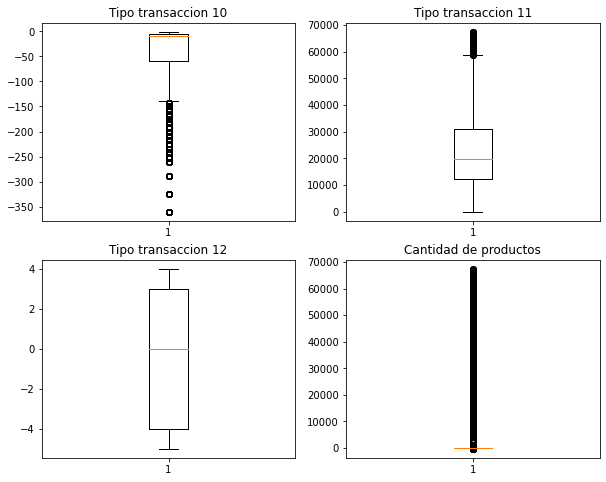

In [157]:
uno=np.array(movimientos.select('Cantidad').where(movimientos.TipoTransaccionID == 10).collect())
len(uno)
dos=np.array(movimientos.select('Cantidad').where(movimientos.TipoTransaccionID == 11).collect())
tres=np.array(movimientos.select('Cantidad').where(movimientos.TipoTransaccionID == 12).collect())


figure, axis = plt.subplots(2, 2,figsize=(10, 8))
  
# For one Function
axis[0, 0].boxplot(uno)
axis[0, 0].set_title("Tipo transaccion 10")
  
# For two Function
axis[0, 1].boxplot(dos)
axis[0, 1].set_title("Tipo transaccion 11")
  
# For tre Function
axis[1, 0].boxplot(tres)
axis[1, 0].set_title("Tipo transaccion 12")

# For tre Function
axis[1, 1].boxplot(np.array(movimientos.select('Cantidad').collect()))
axis[1, 1].set_title("Cantidad de productos")
  
# Combine all the operations and display
plt.show()

Hemos llevado a cabo un análisis a través de un diagrama de caja con el propósito de evaluar la validez de los movimientos de productos, tanto desde la perspectiva de los diferentes "Tipos de Transacción" como desde una visión general. Este análisis se ha realizado con el objetivo de confirmar las hipótesis planteadas previamente.

No obstante, al examinar los datos en su totalidad, hemos notado que el diagrama de caja no arroja una conclusión definitiva en ningún sentido. Esto se debe a la presencia de valores tanto positivos como negativos que distorsionan la visualización de la información proporcionada. Es por esta razón que hemos decidido llevar a cabo un enfoque de análisis alternativo.

Durante este proceso, hemos identificado posibles datos atípicos en este campo. Por lo tanto, consideramos de vital importancia coordinar una sesión de colaboración con el equipo de negocio para investigar la posibilidad de que los movimientos de compra y venta de productos puedan o no presentar estos comportamientos en los valores que se encuentran por fuera del rango intercuartílico (entre el 2º y 4º cuartil) de la información proporcionada. Esto nos permitirá obtener un entendimiento más profundo de la naturaleza de estos datos atípicos y su influencia en nuestro análisis.

In [158]:
movimientos.filter((movimientos.TipoTransaccionID == "10" ) &
                       (movimientos.Cantidad >= -100)).show()

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
|               290145|       213|               10|     33.0|  60795.0|           |               |     Dec 23,2015|    -3.0|
|               247492|        90|               10|     55.0|  51851.0|           |               |     Jul 27

In [159]:
movimientos.filter((movimientos.TipoTransaccionID == "11" ) &
                       (movimientos.Cantidad >= 60000)).show()

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               329831|       193|               11|      0.0|      0.0|        7.0|         2040.0|     May 11,2016| 65520.0|
|               332332|       193|               11|      0.0|      0.0|        7.0|         2053.0|     May 19,2016| 65904.0|
|               314642|       193|               11|      0.0|      0.0|        7.0|         1956.0|     Mar 22,2016| 62688.0|
|               334872|       193|               11|      0.0|      0.0|        7.0|         2067.0|     May 27,2016| 67200.0|
|               301429|       193|               11|      0.0|      0.0|        7.0|         1872.0|     Feb 01

+-----------------+-------------+
|TipoTransaccionID|sum(Cantidad)|
+-----------------+-------------+
|               12|        -24.0|
|               10|   -7714426.0|
|               11| 1.54702496E8|
+-----------------+-------------+

+-----------------+------+
|TipoTransaccionID| count|
+-----------------+------+
|               12|    46|
|               10|197136|
|               11|  7110|
+-----------------+------+



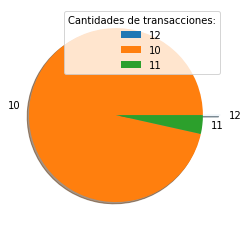

0.9649717071642551


In [160]:
movimientos.groupBy("TipoTransaccionID").sum("Cantidad").show()
movimientos.groupBy("TipoTransaccionID").count().show()
hi=np.array(movimientos.groupBy("TipoTransaccionID").count().collect())
c = [hi[i][0] for i in range(len(hi))]
d= [hi[i][1] for i in range(len(hi))]
myexplode = [0.2, 0, 0]
plt.pie(d, labels = c, explode = myexplode, shadow = True)
plt.legend(title = "Cantidades de transacciones:")
plt.show() 
print(197136/rows)

Hemos llevado a cabo un análisis de las cantidades de productos "vendidos" y "comprados", lo que nos ha permitido validar la información proporcionada por la organización. Según las indicaciones de la organización, se establece que las compras se efectúan al por mayor, mientras que las ventas se realizan al por menor. Al examinar las cantidades de transacciones "vendidas," observamos que estas representan aproximadamente el 96% de la información suministrada. Sin embargo, es importante destacar que la cantidad total de ventas se sitúa considerablemente por debajo de la cantidad de productos adquiridos.

Esta es una interpretación inicial y general de los datos que, no obstante, deberá ser validada en análisis posteriores para obtener una comprensión más precisa de la relación entre las compras al por mayor y las ventas al por menor, así como para confirmar si las cifras coinciden con la estrategia comercial de la organización.

In [161]:
movimientos.groupby("ProveedorID").count().orderBy("count", ascending=False).show(5)

+-----------+------+
|ProveedorID| count|
+-----------+------+
|           |197182|
|        4.0|  4832|
|        7.0|  2267|
|        1.0|    11|
+-----------+------+



In [162]:
movimientos.filter(movimientos.TipoTransaccionID == "11" ).show(3)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               197005|        80|               11|      0.0|      0.0|        4.0|         1272.0|     Feb 10,2015| 11148.0|
|               111093|        95|               11|      0.0|      0.0|        4.0|          745.0|     Mar 27,2014|  7764.0|
|               329831|       193|               11|      0.0|      0.0|        7.0|         2040.0|     May 11,2016| 65520.0|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
only showing top 3 rows



In [163]:
movimientos.filter(movimientos.TipoTransaccionID == "10" ).show(3)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
only showing top 3 rows



Se validan las transacciones por tipo y se observa que cuando se encuentran las "ventas" el ClienteID trae información pero las columnas ProveedorID y OrdenDeCompraID están "vacíos"; mientas cuando se encuentra información de "compras" de productos el ClienteID e InvoiceID registra el valor **"cero"** es necesario consultar al negocio y realizar los ajustes puesto que puede generar errores en los análisis estas diferencias en la información entregada.

## Análisis de calidad de datos

### Unicidad y validez
La revisión de la unicidad se llevó a cabo al analizar la segunda regla de negocio, y la validez se evaluó en el perfilamiento general, así como en la verificación de las reglas de negocio en su totalidad. Aparentemente, se han identificado problemas de unicidad en los movimientos entregados, ya que se han encontrado entidades duplicadas en los datos.

A partir de estos hallazgos, se deduce que la información no se encuentra completa y que existen problemas relacionados con la validez de algunas columnas, como las fechas y posiblemente en los ID de los proveedores. Estos problemas deben ser abordados y resueltos en colaboración con el negocio para garantizar la integridad y la calidad de los datos.

### Completitud y validez

In [165]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()+df.where(df[c] =='').count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

In [74]:
print('detalles de ordenes: ')
columnas_vacias_ordenes = contar_vacios(movimientos)

detalles de ordenes: 
número de vacíos para columna ProveedorID: 197182
número de vacíos para columna OrdenDeCompraID: 197182


Se ha identificado que las columnas que presentan valores vacíos o diferentes de cero son "ProveedorID" y "OrdenDeCompraID," con un total de 197,182 registros. Estos registros corresponden a transacciones de tipo "10," lo que indica ventas realizadas por la compañía.

En relación a la cardinalidad, no se han realizado pruebas en esta etapa, dado que estamos trabajando únicamente con una tabla. Aún no se ha establecido una relación con otras tablas que requiera validación en este contexto.

### Consistencia


In [166]:
reporte = ProfileReport(movimientos.toPandas())
reporte.to_file(PATH+"reporte_prefilamiento.html")

Summarize dataset:  60%|██████    | 12/20 [00:03<00:01,  6.37it/s, Calculate kendall correlation]         C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 76.88it/s]


In [167]:
movimientos.join(
    movimientos.groupBy(movimientos.columns).agg((f.count("*")>1).cast("int").alias("Duplicate_indicator")),
    on=movimientos.columns,
    how="inner"
).groupBy("Duplicate_indicator").count().orderBy("count", ascending=False).show(5)


+-------------------+------+
|Duplicate_indicator| count|
+-------------------+------+
|                  0|143026|
|                  1| 61266|
+-------------------+------+



In [168]:
movimientos.groupby('TransaccionProductoID').count().where('count > 1').sort('count', ascending=False).show()

+---------------------+-----+
|TransaccionProductoID|count|
+---------------------+-----+
|               197953|    2|
|               101055|    2|
|               309597|    2|
|               209326|    2|
|               213516|    2|
|               262183|    2|
|               317340|    2|
|               323250|    2|
|               105665|    2|
|               246097|    2|
|               282680|    2|
|               200379|    2|
|               225359|    2|
|               141299|    2|
|               250485|    2|
|               265863|    2|
|               251316|    2|
|               231502|    2|
|               160009|    2|
|               138920|    2|
+---------------------+-----+
only showing top 20 rows



In [169]:
movimientos.where(movimientos.TransaccionProductoID ==89196).show()

+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|    FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+
|                89196|       166|               10|    832.0|  18686.0|           |               |2013-12-31 12:00:...|   -30.0|
|                89196|       166|               10|    832.0|  18686.0|           |               |2013-12-31 12:00:...|   -30.0|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+



### Sección General del Reporte:

En el informe, se analizaron 9 variables y 204,292 registros, que representan transacciones de productos. De estas variables, 4 son categóricas y 5 numéricas. Es relevante señalar que la herramienta de análisis no validó correctamente las variables, ya que sabemos que hay una variable de tipo datetime que debe ser transformada, y los valores "numéricos" en su mayoría corresponden a identificadores relacionados con la naturaleza de las transacciones de productos.

A pesar de que el informe indica que no hay datos aparentemente vacíos, se ha identificado previamente que existen valores nulos en las columnas "OrdenDeCompraID" y "ProveedorID" en filas que no se están identificando como tales. Esta anomalía debe ser abordada y corregida en etapas posteriores de la consultoría.

El archivo de datos ocupa 11.7 MB en memoria. Se han encontrado 30,633 registros duplicados, lo cual también se ha confirmado manualmente. Es esencial validar esta duplicación, ya que se espera que el ID de cada transacción sea único.

### Sección de Variables del Reporte:

El informe proporciona estadísticas descriptivas, como la media, el mínimo y el máximo, para cada variable, además de histogramas de distribución.

Ninguna de las variables presenta valores nulos. Sin embargo, al analizar individualmente las variables:

"TransaccionProductoID" muestra un 85% de valores distintos, lo cual concuerda con el análisis previo de duplicados. Los ID no revelan patrones particulares de interés o errores de calidad.

"ProductoID" presenta menos del 1% de valores distintos, lo que sugiere una alta rotación de productos. Para comprender mejor este comportamiento, es necesario analizar las cantidades de movimientos relacionadas y verificar si corresponden a productos con movimientos recurrentes o a aquellos con poco movimiento.

"TipoTransaccionID" no presenta novedades y refleja las tres tipologías identificadas. Se observa un alto volumen de transacciones de tipo "10," que se supone corresponden a las ventas de la compañía.

"ClienteID" tiene un número reducido de clientes, con solo 664 ID. Los ID no siguen un patrón lineal y muestran saltos en la numeración. Es necesario explorar la asignación de estos ID en colaboración con el negocio. Además, se observa una recurrencia de compras, que representa aproximadamente el 0.3% de las transacciones, y predomina el valor "0," lo cual se alinea con el comportamiento esperado para compras.

"InvoiceID" no revela problemas evidentes y coincide con los análisis previos.

"ProveedorID" muestra únicamente 4 valores, lo cual podría indicar un error en relación con la regla de negocio y la comprensión del negocio. Además, se observa un valor nulo, que corresponde a las "ventas" de productos y constituye la mayor cantidad de registros entregados.

"OrdenDeCompraID" no presenta inconsistencias y coincide con los análisis previos.

"FechaTransaccion" refleja problemas en el tipo de dato de la tabla. Esto ha dificultado la generación de estadísticas que permitan confirmar o refutar hipótesis. Se requiere una transformación de esta columna para explorar tendencias y abordar las inquietudes planteadas por el negocio acerca de los rangos de fechas.

"Cantidad" es la variable de interés para el negocio. El informe muestra valores tanto negativos como positivos. Para realizar análisis adecuados, es esencial diferenciar estas condiciones. La información del informe dificulta la visualización de los movimientos debido al alto volumen de transacciones negativas, que corresponden a las salidas de productos de la compañía.

### Sección de Interacciones y Correlaciones:

Se han observado correlaciones de Spearman iguales a 1 entre columnas, como "InvoiceID" y "TransaccionProductoID." Esto podría deberse a que ambas columnas contienen números consecutivos con la misma longitud. No obstante, se requieren visualizaciones adicionales para confirmar que no se trata de "columnas" duplicadas. Los análisis anteriores indican que estas columnas no representan información repetida, pero es necesario validar esta conclusión.

In [171]:
df_with_x = movimientos.withColumn("Positivo", when(movimientos.Cantidad<0, "No").otherwise("Si"))
df_with_x.groupBy('Positivo').pivot('TipoTransaccionID').count().show()


+--------+------+----+---+
|Positivo|    10|  11| 12|
+--------+------+----+---+
|      No|197136|null| 22|
|      Si|  null|7110| 24|
+--------+------+----+---+



In [172]:
df_with_x.groupBy('Positivo').pivot('ProveedorID').count().show()

+--------+------+----+----+----+
|Positivo|      | 1.0| 4.0| 7.0|
+--------+------+----+----+----+
|      No|197158|null|null|null|
|      Si|    24|  11|4832|2267|
+--------+------+----+----+----+



In [173]:
corr = movimientos.toPandas().corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

,TransaccionProductoID,ProductoID,TipoTransaccionID,ClienteID,InvoiceID,Cantidad
TransaccionProductoID,1.000000,0.017905,-0.001819,0.021868,0.859235,0.060616
ProductoID,0.017905,1.000000,0.028463,-0.009326,0.001007,0.028805
TipoTransaccionID,-0.001819,0.028463,1.000000,-0.277915,-0.484808,0.833650
ClienteID,0.021868,-0.009326,-0.277915,1.000000,0.154670,-0.234709
InvoiceID,0.859235,0.001007,-0.484808,0.154670,1.000000,-0.409633
Cantidad,0.060616,0.028805,0.833650,-0.234709,-0.409633,1.000000


Se realiza el análisis de acuerdo con lo deducido con los análisis del informe y el reporte generado encontrando que las tipologías de la transacción marcara un valor importante para el análisis de la información y la entrega de la información que permita a WWI en el tablero de control de acuerdo con su objetivo de visualizar los productos vendidos y los stock de productos que pueda suplir estas necesidades.

## Conclusiones

### Conclusiones Generales:

En la tabla de movimientosCopia, se ha recopilado información sobre las entradas y salidas de productos, lo que permite rastrear la naturaleza de estos movimientos, así como identificar a los clientes y proveedores involucrados en las compras y ventas de productos. Para una comprensión completa y para generar un tablero de control efectivo, se requerirá información financiera adicional, específicamente los detalles económicos de los movimientos de productos, que se pueden derivar de las relaciones entre "InvoiceID" y "OrdenDeCompraID". La entrega de esta información adicional debe confirmarse con el negocio.

### Conclusiones de Reglas de Negocio:

Las reglas de negocio proporcionadas han presentado discrepancias durante el análisis de los datos entregados. Por lo tanto, es esencial realizar consultas al negocio para aclarar estas discrepancias y definir si se requieren ajustes en la información proporcionada. Las preguntas y aclaraciones necesarias incluyen:

Aclaración sobre si la afirmación de "50 millones por transacción" se refiere a un valor financiero y si se proporcionará información adicional para la consultoría. ¿Las cantidades entregadas son numéricas o representan una medida (por ejemplo, miles) de productos?
Investigar la discrepancia en el número de productos entre las reglas de negocio y la información entregada. ¿Se trata de un error en la regla o información incompleta?
Aclaración sobre el número de clientes. ¿La regla se ajusta al hecho de que solo hay 664 "ClienteID"? ¿Hay información faltante o se necesita una revisión de la regla?
Investigar el formato de la fecha y si es factible realizar la transformación necesaria para cumplir con los requisitos del Tablero de Control. ¿Se conoce el proceso para hacer ajustes en la columna de fechas?
Confirmar si las suposiciones sobre las tipologías de transacciones son correctas para validar los valores positivos y negativos. ¿Existen errores de calidad en las tipologías?
Conclusiones de Calidad:

En términos de calidad de datos, la tabla no presenta valores nulos, pero se han identificado 30,633 registros duplicados, lo que requiere validación y corrección. La transformación de la columna de fechas es necesaria, ya que el 30% de los datos no cumple con el formato especificado.

Además, se debe confirmar con el negocio si se mantendrán los valores "0" en las columnas "ClienteID" e "InvoiceID" y cómo afectarán los análisis posteriores.

### Conclusiones del Informe ProfileReport:

El informe proporciona una visión general de los datos y confirma algunas de las suposiciones realizadas en los análisis individuales. Además, destaca la importancia de abordar las discrepancias en las reglas de negocio y la necesidad de clarificación y colaboración con el negocio para garantizar la integridad y calidad de los datos.

Se sugiere sostener una sesión con el negocio para plantear las inquietudes y preguntas pendientes y avanzar en la metodología para el análisis y la formulación de un modelo de analítica 1.0. Es esencial destacar que los análisis requieren un entendimiento adicional y reglas claras para el procesamiento y las transformaciones de los datos.

### Requerimiento
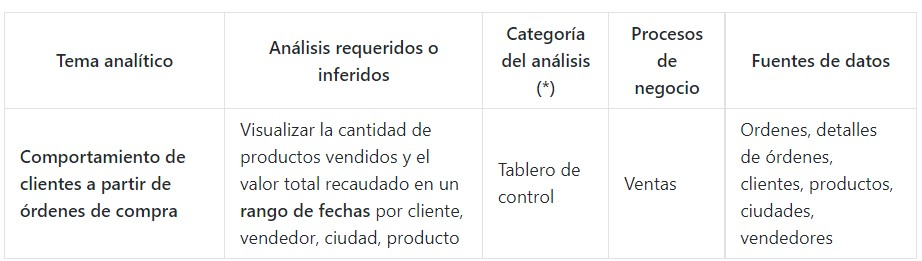

Es una conclusión sólida que resalta la posibilidad de llevar a cabo una Analítica 1.0 para WWI que permita comprender el comportamiento de los clientes a partir de las órdenes de venta y tomar decisiones estratégicas relacionadas con los productos y proveedores. Esto se alinea con los objetivos de ofrecer productos que los clientes desean, brindar un servicio de calidad que maximice las ganancias y optimizar la gestión de inventario.

Sin embargo, es fundamental destacar que para llevar a cabo este análisis, se requieren correcciones en los datos y aclaraciones por parte del negocio para garantizar la integridad y calidad de la información. Además, se destaca la importancia de complementar la información actual con datos de recaudo de ventas y detalles sobre ciudades y vendedores. Esta información adicional es esencial para la creación de tableros de control con las variables requeridas.

En resumen, aunque existe un potencial para realizar un análisis valioso, se necesitará una estrecha colaboración con el negocio y la provisión de datos adicionales para lograr los objetivos de WWI de manera efectiva.

## Cierre

Completado este tutorial ya sabrá la forma básica de utilizar PySpark. Ya sabe cómo crear DataFrames a partir de datos existentes, cómo seleccionar columnas o filas de este Dataframe, cómo rellenar espacios vacíos, cómo aplicar sus propias funciones a estos datos y los más importante, cómo utilizarlo para realizar una fase de entendimiento de datos.

Las tablas detallesOrdenesCopia y OrdenesCopia estaran disponibles en caso de que desee repetir este tutorial cuantas veces considere necesario

## 7. Información adicional

Si quiere conocer más sobre PySpark la guía más detallada es la documentación oficial, la cual puede encontrar acá: https://spark.apache.org/docs/latest/api/python/index.html <br>
Para ir directamente a la documentación de PySpark SQL, donde está la información sobre los DataFrames: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html <br>

El Capítulo 2 del libro <i>Learn PySpark : Build Python-based Machine Learning and Deep Learning Models, New York: Apress. 2019</i> de Pramod Singh contiene muchos ejemplos útiles, puede encontrarlo en la biblioteca virtual de la universidad.

## 8. Preguntas frecuentes

1. Si en el cálculo de los histogramas o en una de sus UDF obtiene el error: TypeError: unsupported operand type(s) for *: 'decimal.Decimal' and 'float' verifique los tipos de las columnas que está intentando operar y, si alguna es double, conviértala a float.

2. En algunos casos, encontrará también información sobre <i>Pandas_UDF</i>. <i>Pandas_UDF</i> son también User Defined Functions, por lo general los Pandas UDF son más eficientes que los UDF tradicionales, sin embargo, hay un bug con la versión de PySpark y de Java que se está usando, lo que previene la utilización de Pandas_UDF.

3. Si al ejecutar la configuración de la sesión Spark le aparece el error <i>Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*])</i> Reinicie el kernel y vuelva a ejecutar
